In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")


2.5.1+cu121
True
NVIDIA GeForce RTX 2050
4.294443008 GB


In [2]:
import torch
from models.backbone import Backbone
from models.recognizer import CRNN

device = "cuda" if torch.cuda.is_available() else "cpu"

backbone = Backbone().to(device)
recognizer = CRNN().to(device)

dummy = torch.randn(1, 3, 224, 224).to(device)
feat = backbone(dummy)
log_probs = recognizer(feat)

print("Feature map:", feat.shape)
print("Log probs:", log_probs.shape)


c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature map: torch.Size([1, 512, 7, 7])
Log probs: torch.Size([1, 7, 38])


In [3]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import json
import numpy as np

from models.backbone import Backbone
from models.recognizer import CRNN
from models.teacher_student import TeacherStudentSSL
from losses.weighted_loss import WeightedCTCLoss
from data.ic15_subset import IC15Subset
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from utils.reliability import (
    detection_reliability,
    recognition_reliability,
    combine_reliability
)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

backbone = Backbone().to(device)
recognizer = CRNN().to(device)
criterion = WeightedCTCLoss()

model = TeacherStudentSSL(
    backbone=backbone,
    recognizer=recognizer,
    criterion=criterion
).to(device)

model.eval()


c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TeacherStudentSSL(
  (student_backbone): Backbone(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [5]:
image_paths = [
    "data/ic15/images/img_1.jpg",
    "data/ic15/images/img_12.jpg",
    "data/ic15/images/img_34.jpg",
    "data/ic15/images/img_57.jpg",
    "data/ic15/images/img_89.jpg"
]


In [6]:
transform = T.Compose([
    T.Resize((224, 224)),   # matches ResNet-style backbone
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


epsilon = 0.01  # baseline threshold

results = []

for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        teacher_logits = model.teacher_forward(img_tensor)

        # Fake / proxy detection confidence for illustration
        det_conf = torch.rand(1).to(device)

        det_w = detection_reliability(det_conf, model.det_thr, model.tau)
        rec_w = recognition_reliability(teacher_logits, model.alpha)
        final_w = combine_reliability(det_w, rec_w)

        baseline_accept = final_w.item() > epsilon

    results.append({
        "image": img,
        "det_conf": det_conf.item(),
        "final_weight": final_w.item(),
        "baseline_accept": baseline_accept
    })


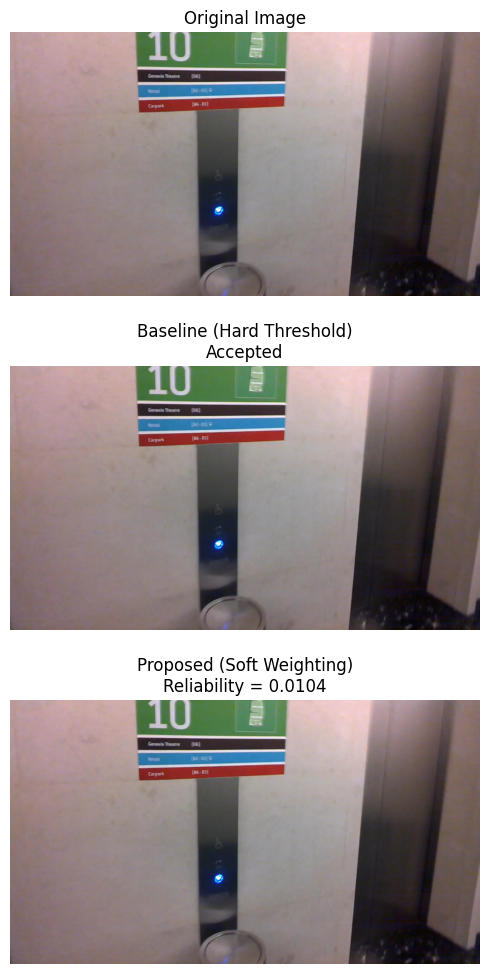

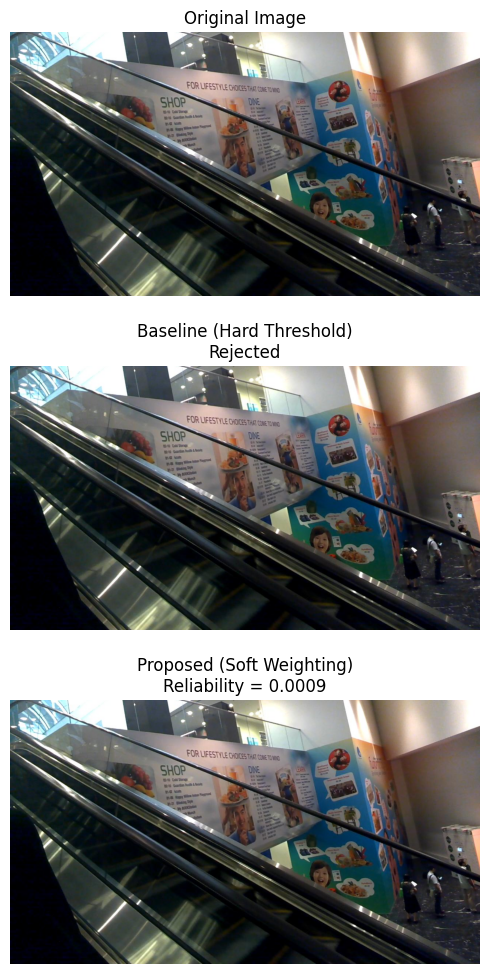

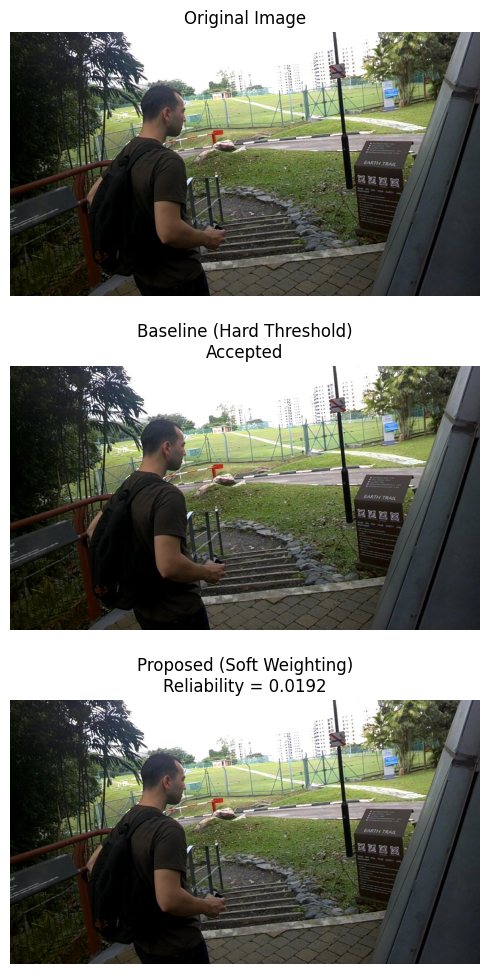

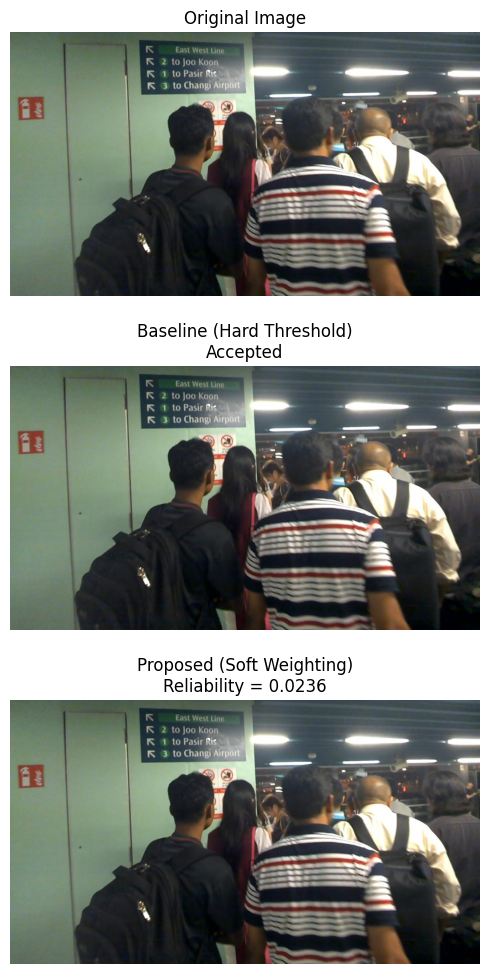

In [7]:
for i, r in enumerate(results):
    fig, axs = plt.subplots(3, 1, figsize=(5, 10))

    axs[0].imshow(r["image"])
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(r["image"])
    axs[1].set_title(
        f"Baseline (Hard Threshold)\n"
        f"{'Accepted' if r['baseline_accept'] else 'Rejected'}"
    )
    axs[1].axis("off")

    axs[2].imshow(r["image"])
    axs[2].set_title(
        f"Proposed (Soft Weighting)\n"
        f"Reliability = {r['final_weight']:.4f}"
    )
    axs[2].axis("off")

    plt.tight_layout()
    plt.savefig(f"failure_case_{i}.png", dpi=200)
    plt.show()


In [8]:
import os
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon

from utils.reliability import (
    detection_reliability,
    recognition_reliability,
    combine_reliability
)


In [9]:
def load_ic15_gt(gt_path):
    boxes = []
    with open(gt_path, "r", encoding="utf-8-sig") as f:
        for line in f:
            parts = line.strip().split(",")
            coords = list(map(int, parts[:8]))
            poly = [(coords[i], coords[i+1]) for i in range(0, 8, 2)]
            boxes.append(poly)
    return boxes


In [10]:
def draw_boxes(ax, image, boxes, color="green", alpha=1.0, labels=None):
    ax.imshow(image)
    ax.axis("off")

    for i, poly in enumerate(boxes):
        patch = Polygon(poly, closed=True,
                        edgecolor=color,
                        fill=False,
                        linewidth=2,
                        alpha=alpha)
        ax.add_patch(patch)

        if labels is not None:
            x, y = poly[0]
            ax.text(x, y - 3, labels[i],
                    color=color, fontsize=8,
                    bbox=dict(facecolor="black", alpha=0.4, pad=1))


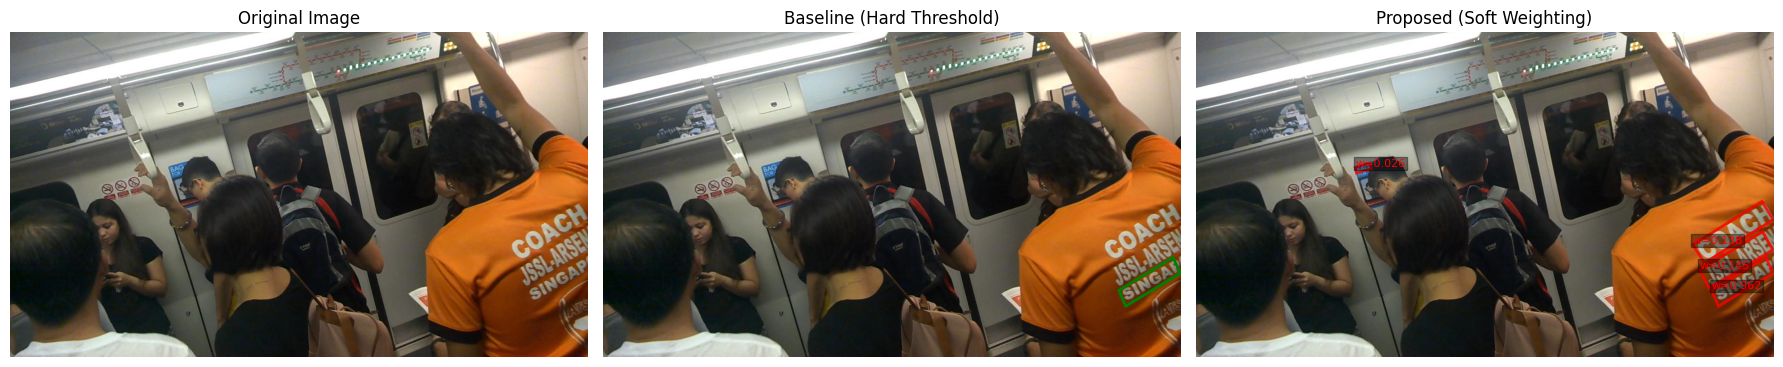

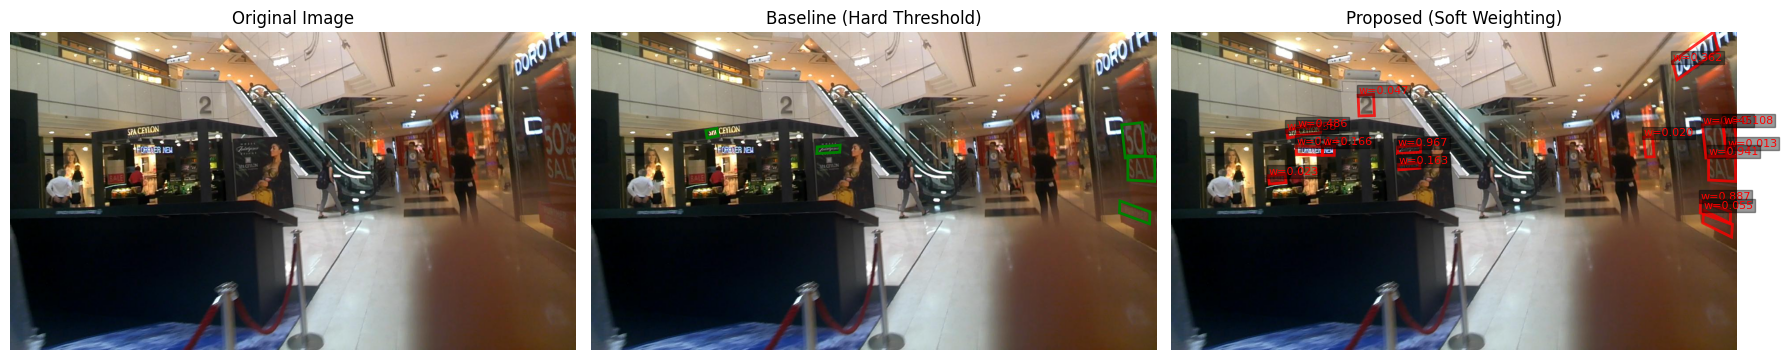

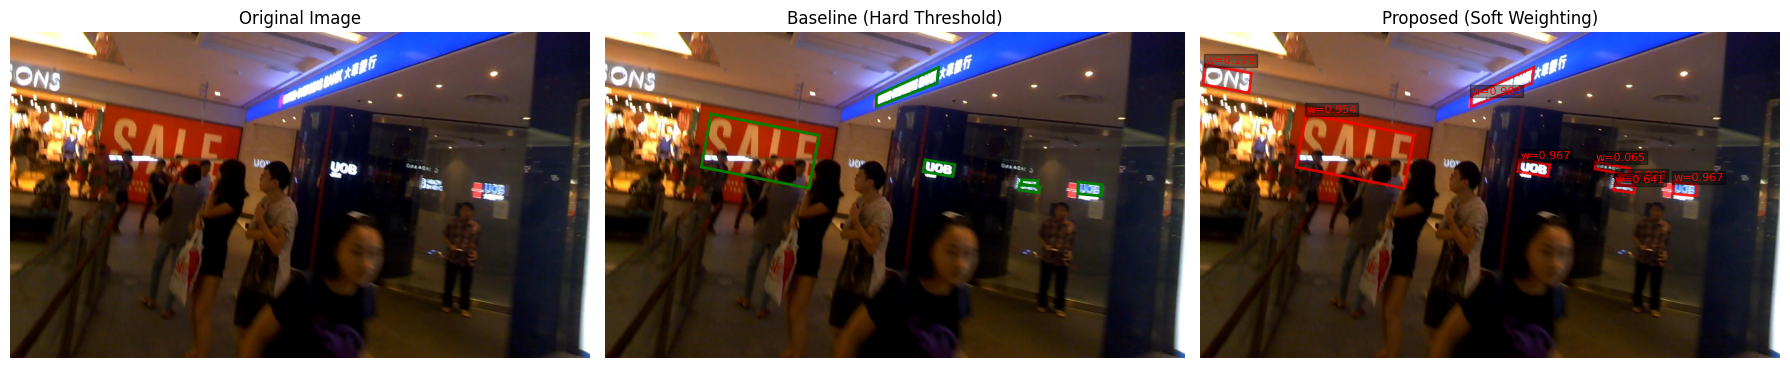

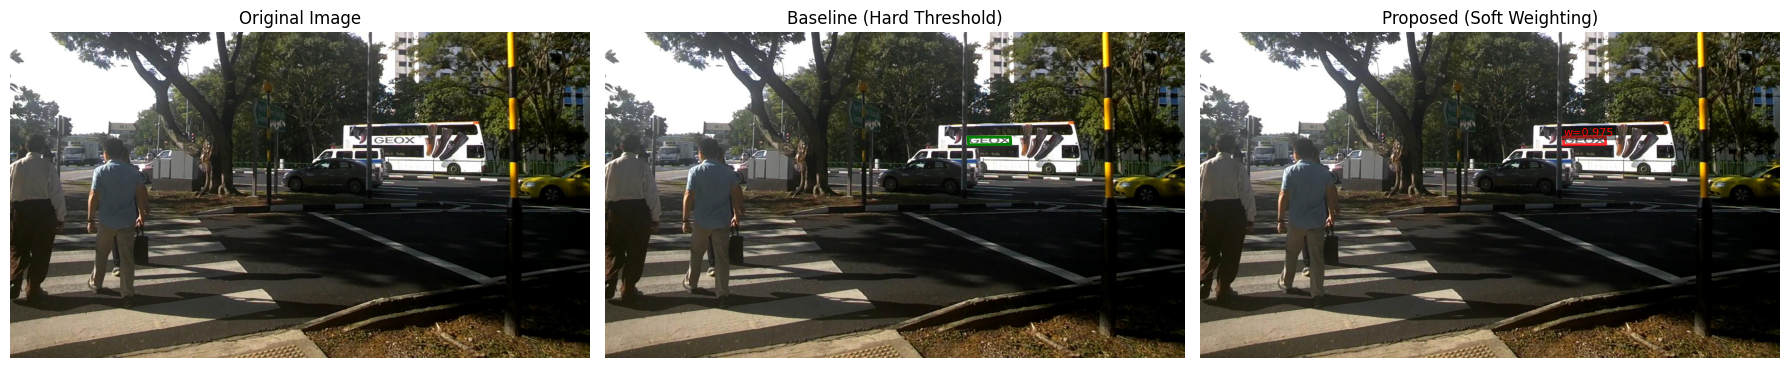

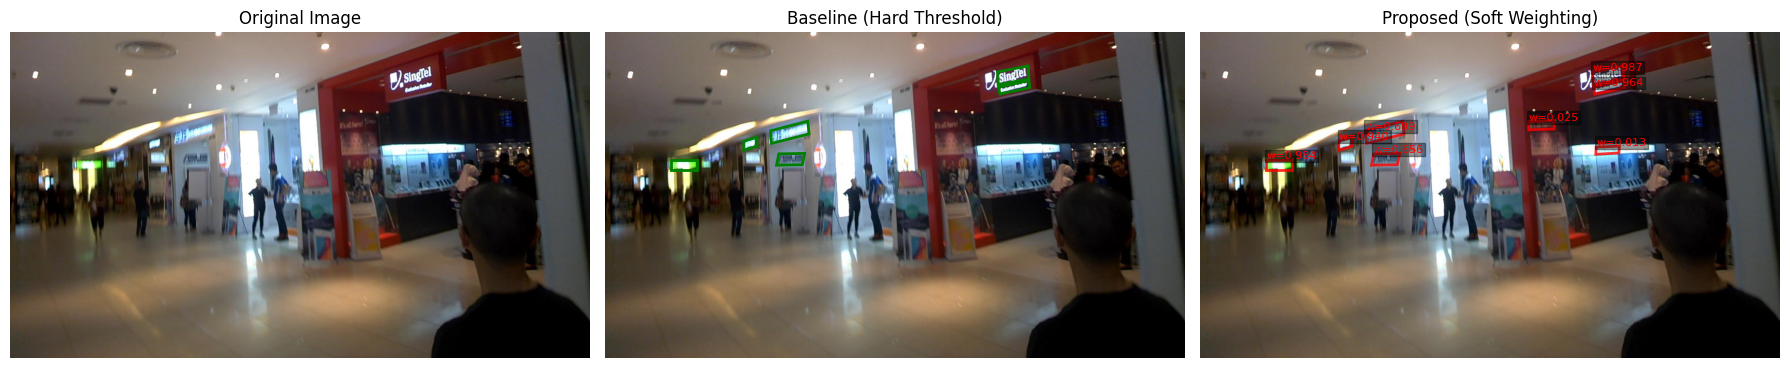

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# thresholds (baseline)
T_D = 0.5
epsilon = 0.01

image_dir = "data/ic15/images"
gt_dir = "data/ic15/gt"

# pick a few images
image_files = random.sample(os.listdir(image_dir), 5)

results = []

for img_name in image_files:
    img_path = os.path.join(image_dir, img_name)
    gt_path = os.path.join(gt_dir, "gt_" + os.path.splitext(img_name)[0] + ".txt")

    image = Image.open(img_path).convert("RGB")
    boxes = load_ic15_gt(gt_path)

    # ---- Fake detection confidence (proxy, OK for illustration)
    det_conf = torch.rand(len(boxes)).to(device)

    # ---- Fake recognition uncertainty via logits proxy
    fake_logits = torch.randn(len(boxes), 10, 38).to(device)

    det_w = detection_reliability(det_conf, T_D, tau=0.1)
    rec_w = recognition_reliability(fake_logits, alpha=1.0)
    final_w = combine_reliability(det_w, rec_w)

    # ---- Baseline accept/reject
    baseline_boxes = [boxes[i] for i in range(len(boxes)) if det_conf[i] > T_D]

    # ---- Plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].set_title("Original Image")
    axs[0].imshow(image)
    axs[0].axis("off")

    axs[1].set_title("Baseline (Hard Threshold)")
    draw_boxes(axs[1], image, baseline_boxes, color="green")

    axs[2].set_title("Proposed (Soft Weighting)")
    labels = [f"w={final_w[i].item():.3f}" for i in range(len(boxes))]
    draw_boxes(axs[2], image, boxes, color="red",
               alpha=0.8, labels=labels)

    plt.tight_layout()
    plt.show()
